In [6]:
#Task 3.A

using Random, Statistics
			
Random.seed!(123)
a, b, rho, sigma = 1.2, 0.5, 0.9, 0.01
T = 500
			
z = zeros(T); x = zeros(T); eps = sigma .* randn(T)
coef = -(b/a) * (1/(1 - rho/a))   # x_t = coef * z_t
			
for t in 2:T
z[t] = rho*z[t-1] + eps[t]
x[t] = coef * z[t]
end
			
			@show mean(x) var(x)    # E[x]=0; Var[x]=coef^2 * Var[z]
			# IRF (H=40): one-std shock at t=1
			H = 40
			irf_z = zeros(H); irf_x = zeros(H)
			irf_z[1] = sigma
			for h in 2:H
			irf_z[h] = rho * irf_z[h-1]
			end
			irf_x .= coef .* irf_z

mean(x) = 0.009806921811462862
var(x) = 0.0008722049563996548


40-element Vector{Float64}:
 -0.016666666666666666
 -0.015000000000000003
 -0.013500000000000003
 -0.012150000000000003
 -0.010935000000000004
 -0.009841500000000003
 -0.008857350000000003
 -0.007971615000000005
 -0.007174453500000004
 -0.006457008150000004
  ⋮
 -0.0006358673741282438
 -0.0005722806367154194
 -0.0005150525730438775
 -0.0004635473157394898
 -0.00041719258416554085
 -0.0003754733257489868
 -0.0003379259931740881
 -0.0003041333938566793
 -0.0002737200544710114

In [ ]:
using LinearAlgebra, Random
using Plots                      

# ---- Shared calibration (same as your block) -------------------------------
const β    = 0.99
const σ    = 1.0
const χ    = 1.55
const η    = 0.0
const θ    = 2.064
const ω    = 0.5
const α    = 3.0
const ρ    = 0.5

# Sims form sizes
const n  = 1   # predetermined
const m  = 2   # jump
const ν  = 1   # shocks
const TIRF = 40

#  build kappa and (A0,A1,B0)
function build_mats(δ; verbose=false)
    κ = (1-ω)*(1-β*ω)/(α*ω)

    A0 = zeros(3,3)
    A1 = zeros(3,3)
    B0 = zeros(3,1)

    # A0
    A0[1,1] = 1.0
    A0[2,2] = 1.0
    A0[2,3] = σ^(-1)
    A0[3,3] = β

    # A1
    A1[1,1] = ρ
    A1[2,1] = σ^(-1)
    A1[2,2] = 1.0
    A1[2,3] = σ^(-1) * δ
    A1[3,2] = -κ
    A1[3,3] = 1.0

    B0[1,1] = 1.0  # shock hits first equation

    A = A0 \ A1
    B = A0 \ B0

    if verbose
        λ = eigvals(A)
        println("lambda = ", vec(real.(λ))')
    end

    return A0, A1, B0, A, B
end

# BK count: number of |λ|>1
bk_unstable_count(A) = count(abs.(eigvals(A)) .> 1.0)

# Solve  and produce decision rules (states first)
# Returns C11, C12, C21 and a boolean for BK satisfied
function solve_rules(A, B)
    vals, vecs = eigen(A)
    ord = sortperm(vals; by = x -> (abs(real(x)), imag(x)))
    λ   = vals[ord]
    M   = vecs[:,ord]                     # eigenvectors (ordered)

    Pinv = M \ I                          # = inv(M), but stabler

    Λ  = Diagonal(λ)
    Λ11 = Λ[1:n, 1:n]

    P11 = Pinv[1:n, 1:n]
    P12 = Pinv[1:n, n+1:n+m]
    P21 = Pinv[n+1:n+m, 1:n]
    P22 = Pinv[n+1:n+m, n+1:n+m]

    R   = Pinv * B           # (n+m)×ν
    R1  = R[1:n, :]          # n×ν

    K   = P11 - P12 * (P22 \ P21)
    C11 = real( (K \ (Λ11 * K)) )         # n×n
    C12 = real( K \ R1 )                  # n×ν
    C21 = real( -(P22 \ P21) )            # m×n  (controls from states)

    bk_ok = (bk_unstable_count(A) == m)
    return C11, C12, C21, bk_ok
end

# IRFs: unit shock at t=1 in first equation
function irfs(C11, C12, C21; T=TIRF, σϵ=1.0)
    s = zeros(n, T)        # states
    c = zeros(m, T)        # controls
    s[:,1] .= C12 .* σϵ

    for t in 1:T
        c[:,t] = C21 * s[:,t]
        t < T && (s[:,t+1] = C11 * s[:,t])
    end
    return c
end



irfs (generic function with 1 method)


=== Scenario A (baseline) : δ = 1.5 ===
lambda = [0.5 1.09006734006734 1.09006734006734]
BK: #unstable = 2 (need 2)
First 5 periods (x, π):
x[1:5] = [-1.2000000000000006, -0.6000000000000003, -0.30000000000000016, -0.15000000000000008, -0.07500000000000004]
π[1:5] = [-0.40000000000000013, -0.20000000000000007, -0.10000000000000003, -0.05000000000000002, -0.02500000000000001]

=== Scenario B (alternative policy) : δ = 1.2 ===
lambda = [0.5 1.0900673400673404 1.0900673400673404]
BK: #unstable = 2 (need 2)
First 5 periods (x, π):
x[1:5] = [-1.3636363636363633, -0.6818181818181817, -0.3409090909090908, -0.17045454545454536, -0.08522727272727268]
π[1:5] = [-0.454545454545454, -0.22727272727272696, -0.11363636363636347, -0.056818181818181726, -0.02840909090909086]


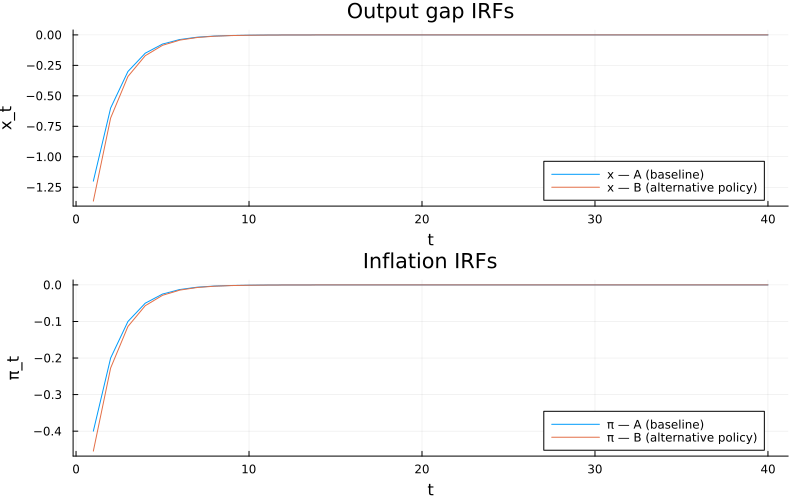

In [ ]:
# ---- Scenarios and results ----------------------------------------
scenarios = [
    ("A (baseline)", 1.5),
    ("B (alternative policy)", 1.2),
]
results = Dict{String, Matrix{Float64}}()

# ---- Run --------------------------------------------------------------------
for (name, δ) in scenarios
    println("\n=== Scenario $name : δ = $δ ===")
    _, _, _, A, B = build_mats(δ; verbose=true)

    bk = bk_unstable_count(A)
    println("BK: #unstable = $bk (need $m)")

    C11, C12, C21, bk_ok = solve_rules(A, B)
    if !bk_ok
        println("⚠ BK not satisfied → skipping IRFs for \"$name\".")
        continue
    end

    C = irfs(C11, C12, C21; T=TIRF, σϵ=1.0)   # rows: 1=x_t, 2=π_t
    results[name] = C

    println("First 5 periods (x, π):")
    println("x[1:5] = ", C[1, 1:5])
    println("π[1:5] = ", C[2, 1:5])
end

# ---- Plot scenarios ---------------------------------------------
if !isempty(results)
    plt = plot(layout=(2,1), size=(800,500))
    for (name, C) in results
        plot!(plt[1], C[1,:], label="x — $name")
        plot!(plt[2], C[2,:], label="π — $name")
    end
    plot!(plt[1], title="Output gap IRFs", xlabel="t", ylabel="x_t")
    plot!(plt[2], title="Inflation IRFs",  xlabel="t", ylabel="π_t")
    display(plt)
else
    @warn "No determinate scenarios—try increasing δ (policy aggressiveness)."
end